In [1]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Connecting to Google Drive and mount project to running instance

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Need to manually set project path.
fpath='/content/drive/MyDrive/Colab Notebooks/Capstone'

print(f"Project filepath, fpath: {fpath}")

file_path_censo = fpath+'/data/Comercial_Censo.csv'
file_path_metero = fpath+'/data/Comercial_Meteorología.csv'
file_path_test = fpath+'/data/Comercial_Test.csv'
file_path_ventas = fpath+'/data/Comercial_Ventas.csv'
file_path_ventas_test = fpath+'/data/Comercial_Test.csv'

data_censo = pd.read_csv(file_path_censo, delimiter=';', encoding='latin1', decimal=',',thousands='.')
data_meteoro = pd.read_csv(file_path_metero, delimiter=',', decimal=',', encoding='latin1',usecols=lambda column: column not in ['Unnamed: 0'])
data_test= pd.read_csv(file_path_test, delimiter=';', encoding='latin1')
data_ventas= pd.read_csv(file_path_ventas, delimiter=';', decimal=',', encoding='latin1')
data_ventas['sale_date']=pd.to_datetime(data_ventas['Dia'], dayfirst=True)

data_ventas_test=pd.read_csv(file_path_ventas_test, delimiter=';', decimal=',', encoding='latin1')
data_ventas_test['sale_date']=pd.to_datetime(data_ventas_test['Dia']) # not the same date format as Comercial_Ventas.csv!


Project filepath, fpath: /content/drive/MyDrive/Colab Notebooks/Capstone


## Find coordiates of towns

In [4]:
# This takes nearly a minute to run as it Nominatim geoservice only allows 1 lookup/sec
getgeo=False  # only fetch once
m_list=[]
if getgeo:
    for m in data_censo.Municipio.str.split(' ').apply(lambda x:[x[0],x[1]]):
        if int(m[0])>100:
            mlu=m[1]+", A Coruña"
            mlo=geolocator.geocode(mlu)
            m_list.append([m[0],m[1],mlo.latitude,mlo.longitude])

    df_m=pd.DataFrame(columns=['Town_no','Town','Latitud','Longitud'])

    for mu in m_list:
        df_m=pd.concat((df_m,pd.DataFrame(columns=['Town_no','Town','Latitud','Longitud'],data=[[mu[0],mu[1],mu[2],mu[3]]])))

    df_m.to_pickle(fpath+'/data/df_m.pkl')
else:
    df_m=pd.read_pickle(fpath+'/data/df_m.pkl')


## Find distances between stations and towns

In [5]:
# get stations (after cleaning)
stations=pd.read_pickle(fpath+'/data/stations.pkl')


from geopy import distance

for i,r in stations.iterrows():
    s=(r.Latitud,r.Longitud)
    df_m[f'km2st{r.Number:0d}']=df_m.loc[:,['Latitud','Longitud']].apply(lambda x:distance.distance(s,(x.Latitud,x.Longitud)).km,axis=1)
    stations[f'km2st{r.Number:0d}']=stations.loc[:,['Latitud','Longitud']].apply(lambda x:distance.distance(s,(x.Latitud,x.Longitud)).km,axis=1).round(2)


In [6]:
stations.sort_values(by='Number',inplace=True)
stations.set_index('Number')


,Nombre,Latitud,Longitud,km2st1,km2st10,km2st11,km2st12,km2st2,km2st3,km2st4,km2st5,km2st6,km2st7,km2st8,km2st9
Number,,,,,,,,,,,,,,,
1,ES1,43.114013,-8.147955,0.00,36.68,25.65,39.81,43.62,35.82,35.15,28.20,27.58,31.98,35.73,31.98
2,ES2,43.502874,-8.221867,43.62,22.05,18.01,5.93,0.00,35.49,29.30,24.18,17.84,22.93,35.51,23.82
3,ES3,43.275401,-8.529408,35.82,13.62,27.42,36.95,35.49,0.00,6.20,13.93,22.55,13.07,0.09,12.16
4,ES4,43.317490,-8.479238,35.15,7.45,22.50,30.93,29.30,6.20,0.00,9.27,17.35,7.33,6.22,6.48
5,ES5,43.311974,-8.365214,28.20,8.48,13.50,24.26,24.18,13.93,9.27,0.00,8.68,3.78,13.90,3.86
6,ES6,43.346004,-8.268857,27.58,13.24,5.31,16.49,17.84,22.55,17.35,8.68,0.00,10.16,22.52,10.92
7,ES7,43.338868,-8.393727,31.98,4.70,15.41,23.92,22.93,13.07,7.33,3.78,10.16,0.00,13.07,0.92
8,ES8,43.274713,-8.528744,35.73,13.65,27.39,36.95,35.51,0.09,6.22,13.90,22.52,13.07,0.00,12.16
9,ES9,43.333647,-8.402475,31.98,4.84,16.14,24.84,23.82,12.16,6.48,3.86,10.92,0.92,12.16,0.00


In [7]:
# find the closest station to each other station (used in model 8)

stdist=stations.set_index('Nombre').loc[:,'km2st1':]
stn_near=stdist[stdist>0.1].idxmin(axis=1,skipna=True).to_frame()\
    .apply(lambda x:'ES'+x[0].split('st')[1],axis=1).to_frame().rename(columns={0:'Nearest'})
stn_near.to_pickle(fpath+'/data/stn_near.pkl')
stn_near

,Nearest
Nombre,
ES1,ES11
ES2,ES12
ES3,ES4
ES4,ES3
ES5,ES7
ES6,ES11
ES7,ES9
ES8,ES4
ES9,ES7


## Plot towns and stations on map

In [8]:
import geopandas as gpd


#shapefile found: https://simplemaps.com/gis/country/es#admin2
spain=gpd.read_file(fpath+"/data/es.json")


In [9]:
df_m

,Town_no,Town,Latitud,Longitud,km2st1,km2st10,km2st11,km2st12,km2st2,km2st3,km2st4,km2st5,km2st6,km2st7,km2st8,km2st9
0,15001,Abegondo,43.213755,-8.289644,15.986203,20.956600,15.793745,30.529290,32.587547,20.642115,19.229157,12.518679,14.789243,16.266191,20.566061,16.165153
0,15002,Ames,42.908393,-8.657106,47.379317,54.888630,60.616092,74.461318,74.919999,42.077291,47.698510,50.741528,57.979767,52.406755,42.016716,51.588370
0,15003,Aranga,43.223073,-8.012443,16.377691,37.606378,20.332842,30.218151,35.418884,42.383506,39.320485,30.295320,24.892592,33.515453,42.319890,33.959346
0,15004,Ares,43.426330,-8.244039,35.563718,16.026575,9.998106,8.381149,8.691384,28.573829,22.574114,16.058530,9.147950,15.541933,28.575308,16.458198
0,15005,Arteixo,43.304594,-8.508275,36.133959,10.018427,25.040470,33.684592,31.992778,3.668887,2.757170,11.635722,19.956615,10.041420,3.712152,9.169180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,15089,Vedra,42.786130,-8.427607,42.983876,65.206374,64.315427,79.231167,81.366968,54.984324,59.180442,58.638722,63.528603,61.467850,54.900673,60.860324
0,15091,Vilarmaior,43.355074,-8.138645,26.791901,23.531337,5.491014,13.152878,17.749554,32.912412,27.934175,18.988151,10.605026,20.760459,32.881349,21.524449
0,15090,Vilasantar,43.076121,-8.095942,5.970971,42.611270,30.732690,44.332691,48.500401,41.620858,41.105239,34.141238,33.112322,37.916997,41.534683,37.935993
0,15092,Vimianzo,43.110299,-9.032749,72.016468,57.145942,72.077568,81.312948,78.933610,44.837603,50.524744,58.689516,67.355840,57.793546,44.855925,56.902667


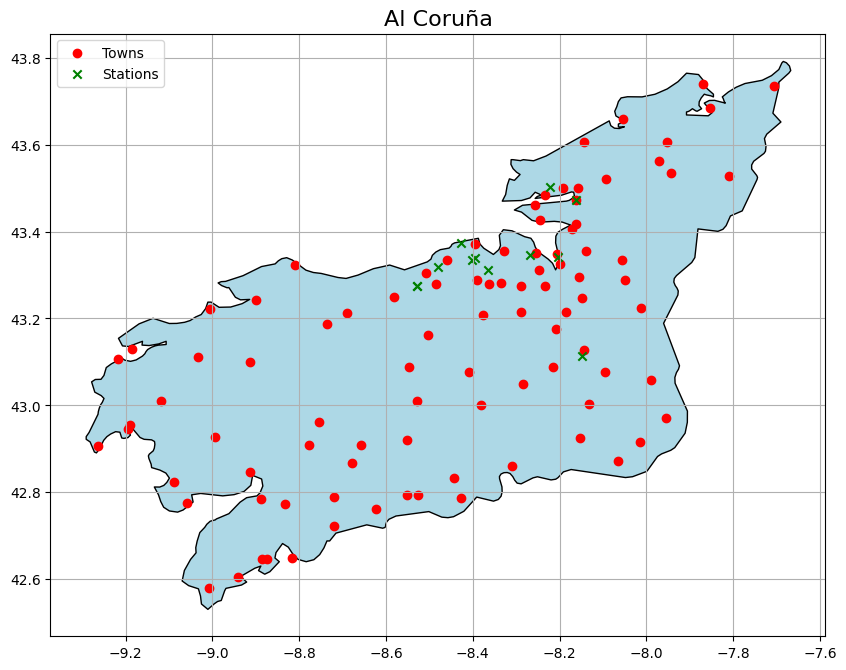

In [10]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
spain.loc[spain.id=='ESC'].plot(color='lightblue',edgecolor='black',ax=ax)


gpd_towns=gpd.GeoDataFrame(df_m.loc[:,['Town','Longitud','Latitud']], geometry=gpd.points_from_xy(df_m.Longitud, df_m.Latitud))
gpd_stations=gpd.GeoDataFrame(stations.loc[:,['Nombre','Number']],geometry=gpd.points_from_xy(stations.Longitud,stations.Latitud))

gpd_towns.plot(ax=ax,color='red')
gpd_stations.plot(ax=ax,color='green',marker='x')
ax.grid('both')
ax.set_title('Al Coru\xf1a',fontsize=16);
ax.legend(['Towns','Stations'])

<Axes: title={'center': 'Al Coruña'}>

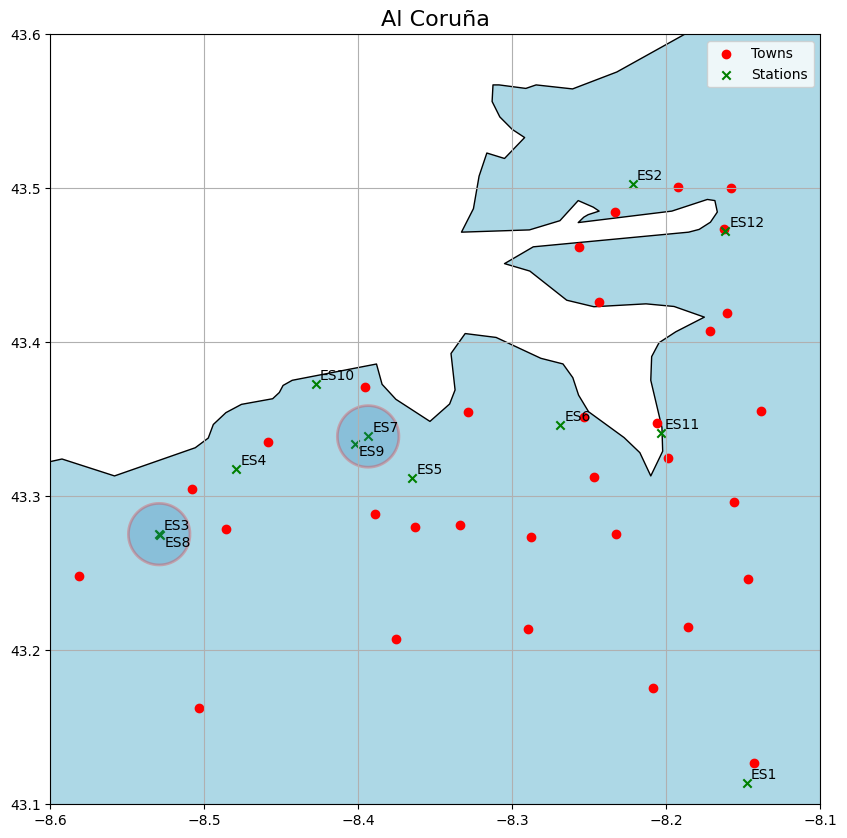

In [11]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
spain.loc[spain.id=='ESC'].plot(color='lightblue',edgecolor='black',ax=ax)

gpd_towns=gpd.GeoDataFrame(df_m.loc[:,['Town','Longitud','Latitud']], geometry=gpd.points_from_xy(df_m.Longitud, df_m.Latitud))
gpd_stations=gpd.GeoDataFrame(stations.loc[:,['Nombre','Number']],geometry=gpd.points_from_xy(stations.Longitud,stations.Latitud))

gpd_towns.plot(ax=ax,color='red')
gpd_stations.plot(ax=ax,color='green',marker='x')
ax.grid('both')
ax.set_title('Al Coru\xf1a',fontsize=16);
ax.legend(['Towns','Stations'])
ax.set_xlim(-8.6,-8.1)
ax.set_ylim(43.1,43.6)
for i,r in stations.iterrows():
    if r.Nombre in ['ES8','ES9']:
        dlat=0.01
    else:
        dlat=0.0
    ax.annotate(r.Nombre,xy=(r.Longitud, r.Latitud-dlat), xytext=(3, 3), textcoords="offset points")

gpd_c=gpd_stations.loc[gpd_stations.Number.isin([3,7]),:].copy()

gpd_c['geometry'] = gpd_c['geometry'].buffer(0.02)
gpd_c.plot(ax=ax,alpha=0.25,ec='r',lw=2)